# Can luminosity distribution explain FRB flux distribution?

## First, model luminosity distribution

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pylab as pl
from scipy.optimize import curve_fit
import astropy.cosmology as cosmo
import astropy.units as u

In [26]:
# reference values and functions
lum_s = lambda ld, s: s*1e-23 * (4*np.pi*ld**2) * 5e-3 * 1.024e9 # lum in erg, s in Jy, ld in cm
plaw = lambda ll, alpha, a: a*(ll/ll[0])**alpha

co = cosmo.Planck15
ld0 = co.luminosity_distance(0.193)

lum0 = np.array([1.5, 12, 0.6, 0.4, 2.1, 0.2, 0.4, 0.6, 0.6])* 1e39
lum0.sort()

Powerlaw slope -0.595096394487 and amplitude 9.74781765219 (at L=2e+38)


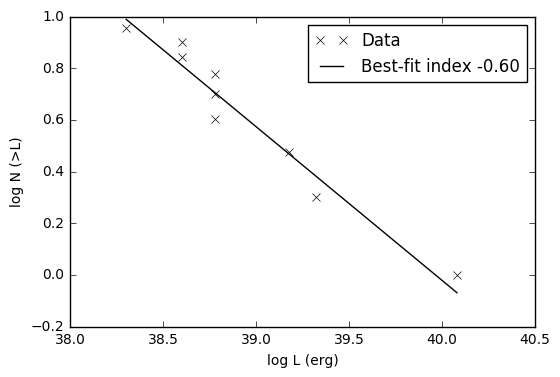

In [49]:
# fit and plot
cnt = np.arange(1,len(lum0)+1)[::-1]
popt0, pcov0 = curve_fit(plaw, lum0, cnt, sigma=np.sqrt(cnt), p0=(-1, 10))
print('Powerlaw slope {0} and amplitude {1} (at L={2})'.format(popt0[0], popt0[1], lum0[0]))

pl.plot(np.log10(lum0), np.log10(cnt), 'kx', label='Data')
pl.plot(np.log10(lum0), np.log10(plaw(lum0, *popt0)), '-k', label='Best-fit index {0:.2f}'.format(popt0[0]))
pl.xlabel('log L (erg)')
pl.ylabel('log N (>L)')
pl.legend()

## Simulate population

In [50]:
def simulate(zr, lr, popt, nsim=1000):
    """ Simulate FRBs over redshift range and luminosity range
    FRB distribution should trace volume and lum distribution
    One FRB per source."""
    
    z_min, z_max = zr
    l_min, l_max = lr
    
    # log luminosity grid
    lumsim = np.logspace(np.log10(l_min), np.log10(l_max), 1000)
    # uniform redshift grid
    zgrid = np.linspace(z_min, z_max, 1000)
    # volume per redshift bin
    vols = np.array([co.comoving_volume(zgrid[i+1]).value - co.comoving_volume(zgrid[i]).value
                     for i in range(len(zgrid)-1)])

    # simulate independent sources. one burst per source
    lums = []
    fluxes = []
    zs = []
    rate = plaw(lumsim, *popt)
    for i in range(nsim):
        z = np.random.choice(zgrid[:-1], p=vols/vols.sum())  # choose redshift with probablility scaling by volume per bin
        zs.append(z)
        lum = np.random.choice(lumsim, p=rate/rate.sum())  # choose flux with probability scaling by rate
        lums.append(lum)
        ff = lum/(4*np.pi*co.luminosity_distance(z).to(u.cm).value**2)  # make a source flux distribution
        fluxes.append(ff)

    fluxes = np.array(fluxes)
    fluxes.sort()
    lums = np.array(lums)
    lums.sort()
    
    return zs, fluxes, lums


def model(zs, fluxes, lums, top=20, show=True):
    """ Model flux distribution and optionally plots them.
    Returns best fit powerlaw to top flux values.
    """
    
    # fit all fluxes (infinite sensitivity)
    cntf = np.arange(1, len(fluxes)+1)[::-1]
    poptf, pcovf = curve_fit(plaw, fluxes, cntf, sigma=np.sqrt(cntf), p0=(-1, 1e-3))

    # fit high fluxes (sensitivity limit)
    cnth = np.arange(1, top+1)[::-1]
    popth, pcovh = curve_fit(plaw, fluxes[-top:], cnth, sigma=np.sqrt(cnth), p0=(-1, 1e-3))

    # fit luminosities (to confirm sample is right)
    cntl = np.arange(1, len(lums)+1)[::-1]
    poptl, pcovl = curve_fit(plaw, lums, cntl, sigma=np.sqrt(cntl), p0=(-1, 1e-3))

    if show:
        print('All: Flux slope {0} and amplitude {1} (at F={2})'.format(poptf[0], poptf[1], fluxes[0]))
        print('Top {0}: flux slope {1} and amplitude {2} (at F={3})'.format(top, popth[0], popth[1], fluxes[-top]))
        print('Luminosities: slope {0} and amplitude {1} (at L={2})'.format(poptl[0], poptl[1], lums[0]))

        pl.figure(figsize=(12,5))
        pl.subplot(131)
        pl.plot(np.log10(fluxes), np.log10(cntf), 'kx', label='Fluxes')
        pl.plot(np.log10(fluxes), np.log10(plaw(fluxes, *poptf)), '-r',
                label='Index (all): {0:.2f}'.format(poptf[0]))
        pl.plot(np.log10(fluxes[-top:]), np.log10(plaw(fluxes[-top:], *popth)), '-r',
                label='Index (top {0}): {1:.2f}'.format(top, popth[0]))
        pl.xlabel('log F (erg/cm2)')
        pl.ylabel('log N (>F)')
        pl.legend()
        pl.subplot(132)
        pl.hist(zs)
        pl.xlabel('redshift')
        pl.ylabel('FRB count')
        pl.subplot(133)
        pl.plot(np.log10(lums), np.log10(cntl), 'kx', label='Luminosities')
        pl.plot(np.log10(lums), np.log10(plaw(lums, *poptl)), '-k', label='Best-fit index {0:.2f}'.format(poptl[0]))
        pl.xlabel('Luminosity')
        pl.ylabel('log N (>L)')
        pl.legend()

    return popth

All: Flux slope -1.43766315018 and amplitude 1012.80371597 (at F=3.70799363254e-16)
Top 20: flux slope -1.39205889698 and amplitude 19.6189720345 (at F=5.3179585671e-15)
Luminosities: slope -288.696623068 and amplitude 1408.56903777 (at L=1e+40)


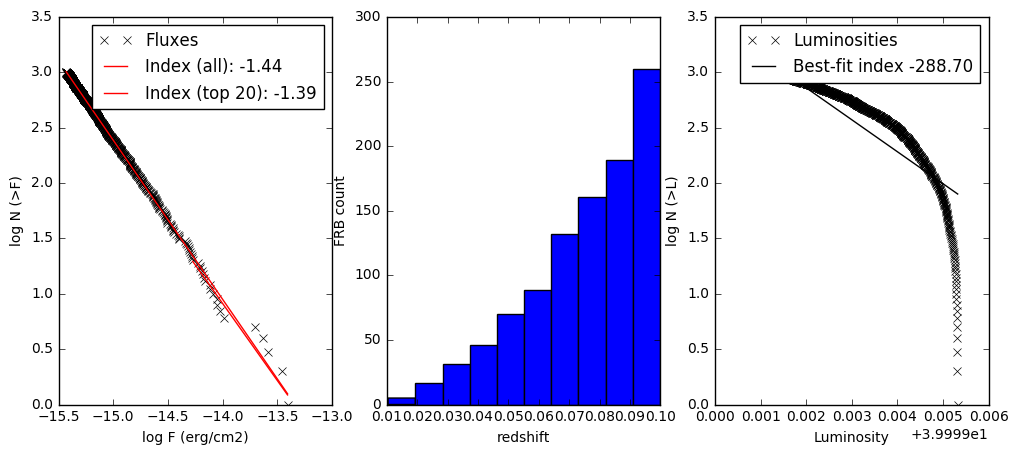

In [74]:
# example using standard candle
zr = 0., 0.1
lr = 1e40, 1.01e40
popt_std = (0, 10)
zs, fluxes, lums = simulate(zr, lr, popt_std, nsim=1000)
popth = model(zs, fluxes, lums)

In [87]:
lr = 1e40, 1.01e40
popt_std = (0, 10)
z_min = 0.
ntr = 10
ci = 0.68
a_ci = {}
for z_max in np.linspace(0.01, 1., 10):
    alphas = []
    for trial in range(ntr):
        zs, fluxes, lums = simulate((z_min, z_max), lr, popt_std, nsim=100)
        popth = model(zs, fluxes, lums, show=False)
        alphas.append(popth[0])
    alphas = np.array(alphas)
    alphas.sort()
    a_ci[z_max] = (alphas[int(ci/2.*ntr)], alphas[-int(ci/2.*ntr)-1])

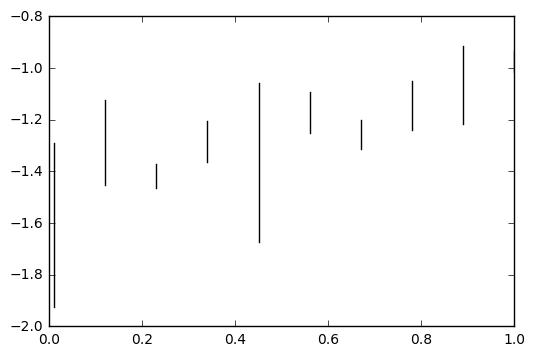

In [88]:
for key in a_ci:
    val = a_ci[key]
    pl.plot([key, key], list(a_ci[key]), 'k-' )